<a href="https://colab.research.google.com/github/cotraak/fake-news-classification-bert/blob/main/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install Libraries

In [1]:
!pip3 install tqdm
!pip3 install transformers
!pip3 install plotly
!pip3 install p_tqdm

In [2]:
import os
import numpy as np
import pandas as pd
import collections
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import ast
from tqdm import tqdm
from fastprogress.fastprogress import master_bar, progress_bar
import tensorflow as tf
import transformers
import matplotlib.pyplot as plt
import re
import warnings
warnings.simplefilter('ignore')
import seaborn as sns

%matplotlib inline

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

print("TF Version: ", tf.__version__)

TF Version:  2.3.0


### Load TPUs

In [3]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


INFO:tensorflow:Initializing the TPU system: grpc://10.99.227.242:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.99.227.242:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU')]


In [4]:
strategy = tf.distribute.TPUStrategy(resolver)

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


### Loading data

In [5]:
true=pd.read_csv('https://cotraak.s3.us-east-2.amazonaws.com/FakeNews/True.csv')
fake=pd.read_csv('https://cotraak.s3.us-east-2.amazonaws.com/FakeNews/Fake.csv')

In [6]:
true['target']=0
true.head()

,title,text,subject,date,target
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0


In [7]:
fake['target']=1
fake.head()

,title,text,subject,date,target
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


In [8]:
data=pd.concat([true,fake],axis=0).reset_index() #concatenating

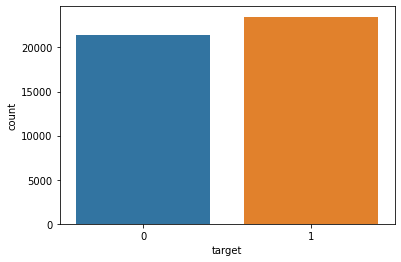

In [9]:
sns.countplot(data['target'])

In [10]:
data['news']=data['title'].str.lower()+'. '+data['text'].str.lower() #combining title and text fields

### Splitting train and test

In [11]:
from sklearn.model_selection import train_test_split
X=data['news'].values
y=data['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True,random_state=42)

### Word distribution

In [12]:
news_lens=data['news'].apply(lambda x: len(str(x).split()))
def mean(l):
  return sum(l)/len(l)
def median(l):
  return l[len(l)//2]
mins,maxs,means,medians=[],[],[],[]
for func in [news_lens]:
  mins.append(min([x for x in func if x!=1]))
  maxs.append(max(func))
  means.append(mean(func))
  medians.append(median(func))
pd.DataFrame([mins,maxs,means,medians], index=['Min','Max','Mean','Median'],columns=['text']).T

,Min,Max,Mean,Median
text,2.0,8148.0,417.737761,489.0


### Tokenizer

In [13]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

In [14]:
MAX_SEQ_LENGTH=512
def create_bert_input_features(docs, max_seq_length=MAX_SEQ_LENGTH):
    
    all_ids, all_masks, all_segments= [], [], []
    for doc in tqdm(docs, desc='Converting Docs to features'):
        tokens = tokenizer.tokenize(doc)
        if len(tokens) > max_seq_length-2:
            tokens = tokens[0 : (max_seq_length-2)]
        tokens = ['[CLS]'] + tokens + ['[SEP]']
        ids = tokenizer.convert_tokens_to_ids(tokens)
        masks = [1] * len(ids)
        # Zero-pad up to the sequence length.
        while len(ids) < max_seq_length:
            ids.append(0)
            masks.append(0)
        segments = [0] * max_seq_length
        all_ids.append(ids)
        all_masks.append(masks)
        all_segments.append(segments)
    encoded = np.array([all_ids, all_masks, all_segments])
    return encoded

In [15]:
train_features_ids, train_features_masks, train_features_segments,test_features_ids, test_features_masks, test_features_segments={},{},{},{},{},{}

mb=['news']

for text in mb:
  train_features_ids[text], train_features_masks[text], train_features_segments[text] =create_bert_input_features(X_train.tolist())

  test_features_ids[text], test_features_masks[text], test_features_segments[text] = create_bert_input_features(X_test.tolist())



Converting Docs to features: 100%|██████████| 14817/14817 [02:25<00:00, 101.93it/s]


### Building Model

In [16]:
maxlength=512
with strategy.scope():
    inp_id = tf.keras.layers.Input(shape=(maxlength,), dtype='int32', name="bert_input_ids")
    inp_mask = tf.keras.layers.Input(shape=(maxlength,), dtype='int32', name="bert_input_masks")
    inp_segment = tf.keras.layers.Input(shape=(maxlength,), dtype='int32', name="bert_segment_ids")
    inputs = [inp_id, inp_mask, inp_segment] 

    hidden_state = transformers.TFBertModel.from_pretrained("bert-base-uncased")(inputs)
    pooled_output = hidden_state[1]
    output = tf.keras.layers.Dense(2, activation='softmax')(pooled_output)
    model = tf.keras.Model(inputs=inputs, outputs=output)
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=2e-5, 
                                              epsilon=1e-08), 
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
bert_input_ids (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
bert_input_masks (InputLayer)   [(None, 512)]        0                                            
__________________________________________________________________________________________________
bert_segment_ids (InputLayer)   [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 512, 768), ( 109482240   bert_input_ids[0][0]             
                                                                 bert_input_masks[0][0]

### Training

In [17]:
batch_size=6
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                      patience=1,
                                      restore_best_weights=True)
model.fit([train_features_ids[text], 
          train_features_masks[text], 
          train_features_segments[text]], y_train, 
          epochs=2,
          batch_size=batch_size,
          validation_split=0.15,
          shuffle=True,
          callbacks=[es],
          verbose=1)

Epoch 1/2
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


   2/4262 [..............................] - ETA: 4:41 - loss: 0.6477 - accuracy: 0.6667WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0138s vs `on_train_batch_end` time: 0.1161s). Check your callbacks.


4262/4262 [==============================] - ETA: 0s - loss: 0.0094 - accuracy: 0.9976WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0040s vs `on_test_batch_end` time: 0.0352s). Check your callbacks.


4262/4262 [==============================] - 612s 143ms/step - loss: 0.0094 - accuracy: 0.9976 - val_loss: 0.0038 - val_accuracy: 0.9993
Epoch 2/2
4262/4262 [==============================] - 597s 140ms/step - loss: 0.0026 - accuracy: 0.9995 - val_loss: 0.0013 - val_accuracy: 0.9998


### Prediction

In [18]:
test_pred=model.predict([test_features_ids[text], test_features_masks[text],  test_features_segments[text]])

In [19]:
y_pred=[x.index(max(x)) for x in test_pred.tolist()]

### Accuracy

In [20]:
import sklearn
accuracy=sklearn.metrics.accuracy_score(y_test, y_pred)
accuracy

0.99919011945738